# Overview
Connects to a Ubiquiti EdgeOS router via SSH and downloads any log files to a locally concatenated CSV file. The logs are parsed for key fields and some additional fields are created. The second part creates a directed Gephi network file to show connection attempts against various ports. Each IP address has an attribute showing the main destination port by count. IP-port combinations outside the top 10 are not colored. All ports are flagged separately for different coloring.

In [1]:
import pandas as pd
import paramiko, re, datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ROUTER_IP = '192.168.10.1'

rules = {
    'rule': re.compile("\[([A-Za-z0-9\-\_]*)\]"),
    'src_ip': re.compile("(?<=SRC\=)(\d+\.\d+\.\d+\.\d+)"),
    'dst_ip': re.compile("(?<=DST\=)(\d+\.\d+\.\d+\.\d+)"),
    'protocol': re.compile("(?<=PROTO\=)([A-Z]+)"),
    'src_port': re.compile("(?<=SPT\=)(\d+)"),
    'dst_port': re.compile("(?<=DPT\=)(\d+)")
}

def get_client(user, password):
    client = paramiko.SSHClient()
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    client.connect(ROUTER_IP ,22, user, password)
    return client

def get_file_names(client):
    path = '/var/log'
    pattern = '"messages*"'
    rawcommand = 'find {path} -name {pattern} -maxdepth 1'
    command = rawcommand.format(path=path, pattern=pattern)
    stdin, stdout, stderr = client.exec_command(command)
    return stdout.read().splitlines()


In [3]:
def parse_date(d):
    dt = datetime.datetime.strptime(d, "%b %d %H:%M:%S")
    dt = dt.replace(year=2017)
    return dt.strftime("%Y/%m/%d %H:%M:%S")

def process_data(user, password, path):
    sftp_client = get_client(user, password)
    sftp_files = get_file_names(sftp_client)
    
    sftp_conn = sftp_client.open_sftp()
    
    lines = []
    for f in sftp_files:
        fd = sftp_conn.open(f)
        for line in fd:
            lines.append(line)
        fd.close()
        print("Processed {FILE}".format(FILE=f))


    hout = "Date,Rule,SourceIp,DestIp,Proto,SourcePort,DestPort\n"
    lout = "{D},{RULE},{SIP},{DIP},{P},{SPT},{DPT}\n"
    
    with open(path,'w') as csv:
        csv.write(hout)
        for l in lines:
            dt = parse_date(l[:15])
            mrule = rules['rule'].search(l)
            msip = rules['src_ip'].search(l)
            mdip = rules['dst_ip'].search(l)
            mproto = rules['protocol'].search(l)
            mspt = rules['src_port'].search(l)
            mdpt = rules['dst_port'].search(l)

            if mrule and mrule and msip and mdip and mproto and mspt and mdpt:
                csv.write(lout.format(
                    D=dt,
                    RULE=mrule.group(1),
                    SIP=msip.group(1),
                    DIP=mdip.group(1),
                    P=mproto.group(1),
                    SPT=mspt.group(1),
                    DPT=mdpt.group(1)))
    print('Combined {N} log files into {F}'.format(N=len(sftp_files), F=path))

In [ ]:
usr = input("Username:")
pwd = input("Password:")

process_data(usr, pwd, 'logout.csv')

In [ ]:
def read_data(path):
    d = pd.read_csv(path)
    d['DateTime'] = pd.to_datetime(d['Date'])
    d['Date'] = d['DateTime'].dt.date
    d['Day'] = d['DateTime'].dt.day
    d['Dow'] = d['DateTime'].dt.dayofweek
    d['Hour'] = d['DateTime'].dt.hour
    d['Month'] = d['DateTime'].dt.month
    d['Count'] = 1
    d['SourceIpFirst3'] = d['SourceIp'].apply(lambda x: '.'.join(x.split('.')[:3]))
    d['DestIpFirst3'] = d['DestIp'].apply(lambda x: '.'.join(x.split('.')[:3]))
    d = d[d['Rule'] == 'WAN_LOCAL-default-D']
    print('Read {N} rows from {P}'.format(N=len(d), P=path))
    return d
data = read_data('logout.csv')
data.head(5)

In [5]:
top_10_ports = data.groupby('DestPort')['Count'].sum().sort_values(ascending=False).head(10).index.values

ip_top_port = data.groupby(['SourceIp','DestPort'])['Count'].sum().reset_index().sort_values(by=['SourceIp','Count'], ascending=[True, False])
ip_top_port = ip_top_port.groupby('SourceIp').head(1).set_index('SourceIp')['DestPort']
ip_top_port = ip_top_port.apply(lambda x: str(x) if x in top_10_ports else 'Other')

edges = data.groupby(['SourceIp','DestPort']).agg({'Count': pd.Series.count}).reset_index().values.tolist()

nodes_ip = data['SourceIp'].unique().tolist()
nodes_port = data['DestPort'].unique().tolist()

In [ ]:
import networkx as nx
G=nx.DiGraph()
G.add_weighted_edges_from(edges)

for p in nodes_ip:
    v = ip_top_port.loc[p]
    G.add_node(p, ntype='ip', mport=v)
G.add_nodes_from(nodes_port, ntype='port', mport='Port')
nx.write_gexf(G, 'output.gexf')

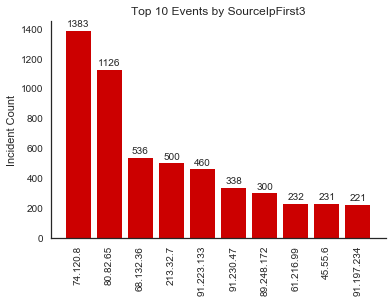

In [6]:
def plot_top_n(data, column, n, color):
    %matplotlib inline
    
    d = data.groupby(column)['Count'].sum().sort_values(ascending=False).head(n)
    x = range(0, n)
    x_lab = d.index.values
    sns.set_style('white')
    plt.figure()
    plt.bar(x, d, color=color)
    
    offset = d.max()*.02
    for l in x:
        plt.text(l, d.iloc[l] + offset, d.iloc[l], ha='center')
    
    plt.title('Top {N} Events by {C}'.format(N=n, C=column), fontsize=12)
    plt.xticks(x, x_lab, rotation=90)
    plt.ylabel('Incident Count')
    sns.despine()
    plt.savefig('{C}-chart.jpg'.format(C=column))

plot_top_n(data, 'SourceIpFirst3', 10, '#CC0000')

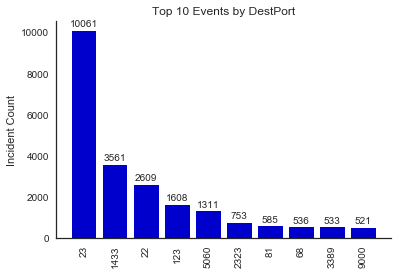

In [7]:
plot_top_n(data, 'DestPort', 10, '#0000CC')

## Calculating combinations of ports
The code here is a little tricky. What we are ultimately looking for are ports which occur with other ports. Meaning, if an IP makes a connection on port 23, what other port does it also connect to? We total these combinations in a pivot which shows the # of unique IPs with that combination of port attempts.

I first get a unique combination of ports and IPs for the top n ports from the original data, which has 1 row per occurance. Then I merge on IP to get combinations of ports tried by that IP. Finally, I sum up the pairs and conver it to a pivot so we can plot with Seaborn

In [79]:
def calc_cross_freq(data, n):
    top_n_ports = data.groupby('DestPort')['SourceIp'].count().sort_values(ascending=False).head(n).sort_index().index.values
    
    # Get unique Port / IP combinations
    ds = data.loc[data['DestPort'].isin(top_n_ports),['DestPort','SourceIp']].drop_duplicates()

    # Merge on IP to get unique pairs per IP
    dm = ds.merge(ds, on='SourceIp')

    ds = dm.groupby(['DestPort_x','DestPort_y']).count().reset_index()
    pv = ds.pivot(index='DestPort_x', columns='DestPort_y', values='SourceIp').fillna(0)
  
    return pv

pvt_data = calc_cross_freq(data, 100)

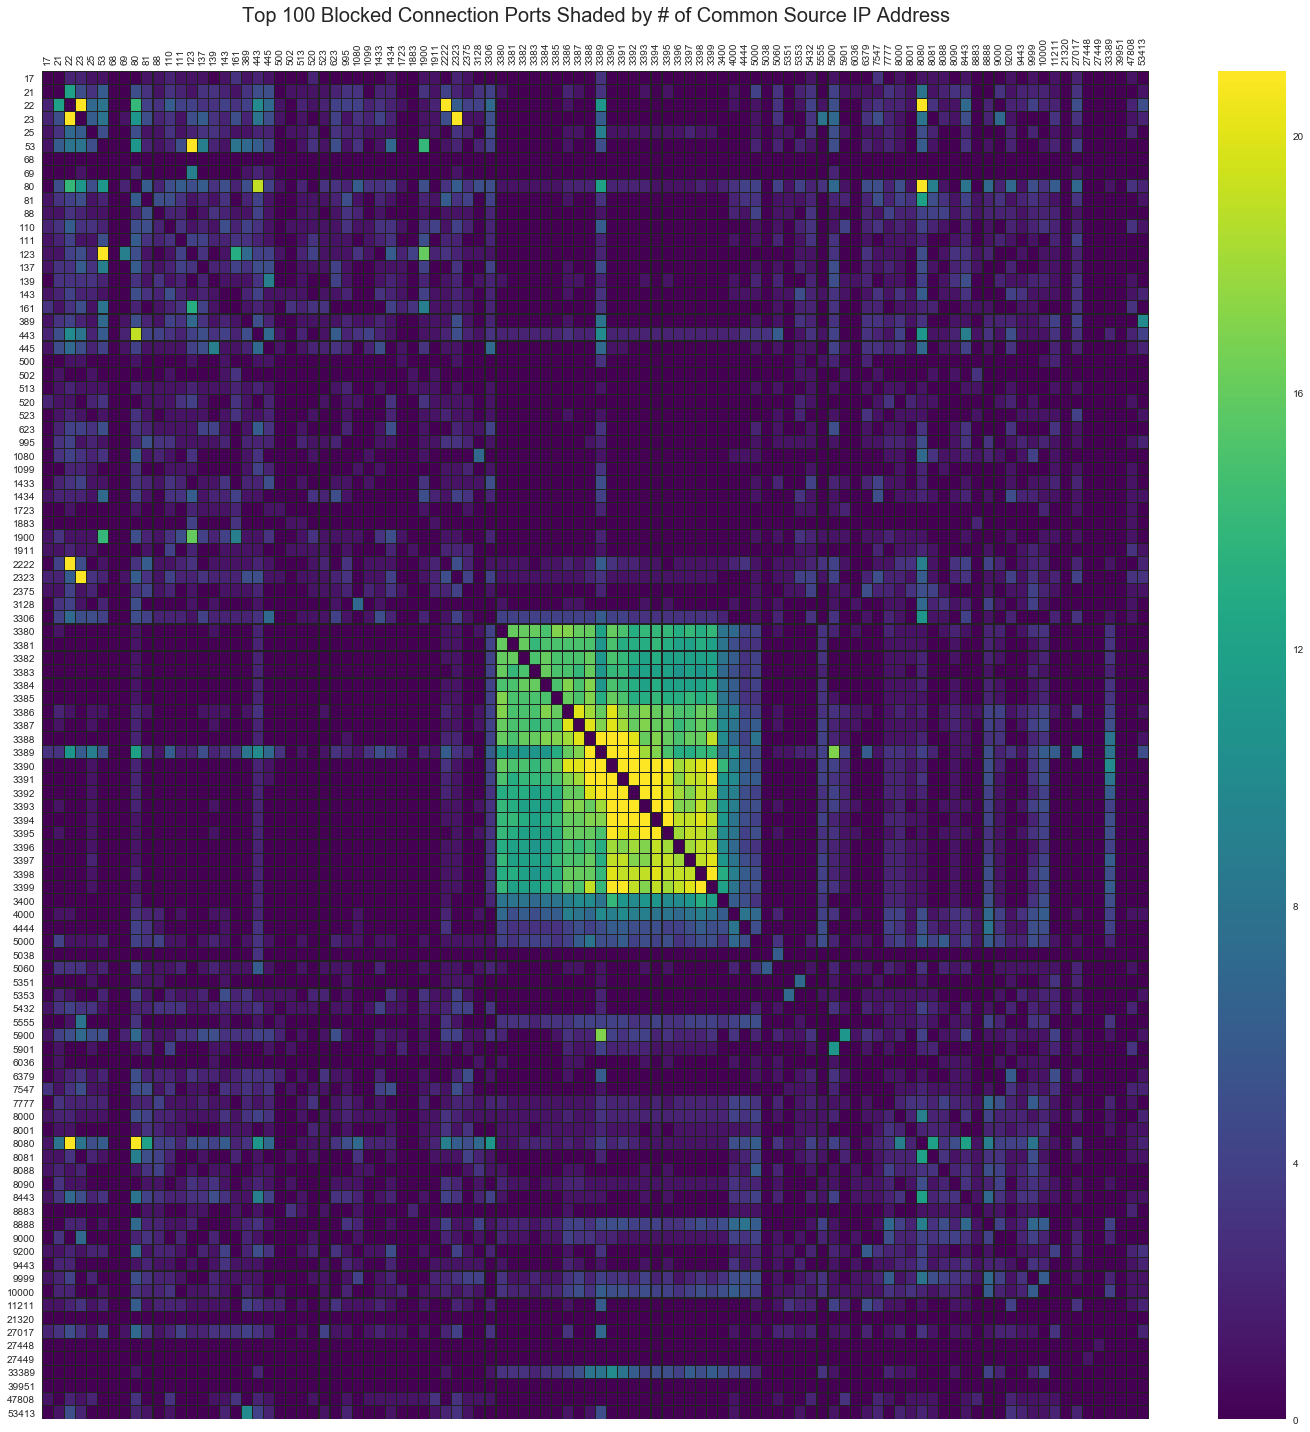

In [85]:
def plot_cross_freq(data):
    # Want to hide the diagonal values which will obviously be high
    a = np.array(data.values)
    np.fill_diagonal(a, 0)
    
    # If we use the full range, a couple of ports (23 - 2323) overwhelm the data and make the shading poor. Instead 99.5
    # percentile
    nmax = np.percentile(a, 99.5)
    
    lab = data.index.values.tolist()
    plt.figure(figsize=(20,20))
    sns.heatmap(a, vmax=nmax, xticklabels=lab, yticklabels = lab, cmap='viridis', linecolor='#222222', linewidths=0.1)
    
    # Format the ticks to the top
    plt.gca().xaxis.tick_top()
    plt.xticks(rotation=90)
    plt.title('Top 100 Blocked Connection Ports Shaded by # of Common Source IP Address\n\n', fontsize=20)
    plt.tight_layout()
    plt.savefig('blocked_map.jpg')
    
plot_cross_freq(pvt_data)
